# **Eye Diseases Classification**

## Importing the Necessary Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

## Load the Dataset

In [ ]:
import os
folder_path = '/kaggle/input/eye-diseases-classification/dataset'

glaucoma = Path(folder_path+'/glaucoma')
cataract = Path(folder_path+'/cataract')
normal = Path(folder_path+'/normal')
diabetic_retinopathy = Path(folder_path+'/diabetic_retinopathy')

In [ ]:
from tqdm import tqdm

disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
#                  0          1      2         3
df = pd.DataFrame()
 # build the dataframe
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/kaggle/input/eye-diseases-classification/dataset/glaucoma: 100%|██████████| 1007/1007 [00:00<00:00, 1924.97it/s]
/kaggle/input/eye-diseases-classification/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1879.61it/s]
/kaggle/input/eye-diseases-classification/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1848.17it/s]
/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1766.43it/s]


In [ ]:
df

,image,disease_type
0,/kaggle/input/eye-diseases-classification/data...,0
1,/kaggle/input/eye-diseases-classification/data...,0
2,/kaggle/input/eye-diseases-classification/data...,0
3,/kaggle/input/eye-diseases-classification/data...,0
4,/kaggle/input/eye-diseases-classification/data...,0
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,3
4213,/kaggle/input/eye-diseases-classification/data...,3
4214,/kaggle/input/eye-diseases-classification/data...,3
4215,/kaggle/input/eye-diseases-classification/data...,3


In [ ]:
df.disease_type.value_counts()

disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64

# Visualizing Images in dataset

In [ ]:
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

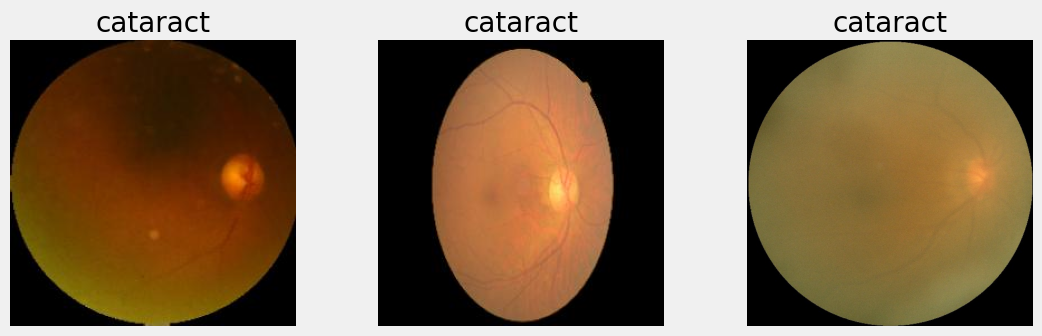

In [ ]:
plot_image(1)

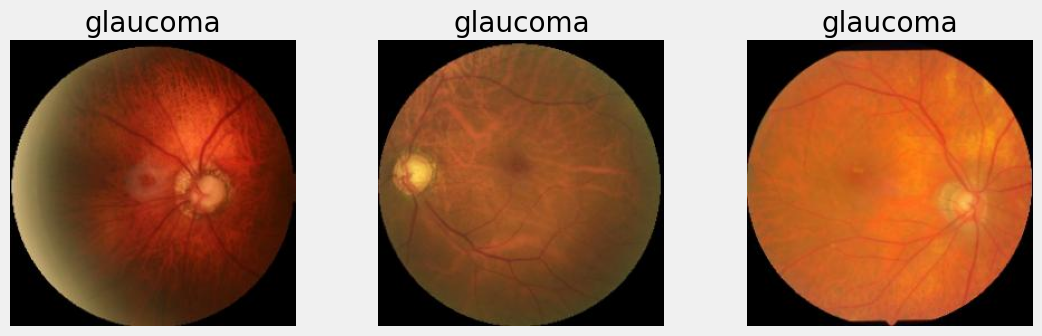

In [ ]:
plot_image(0)

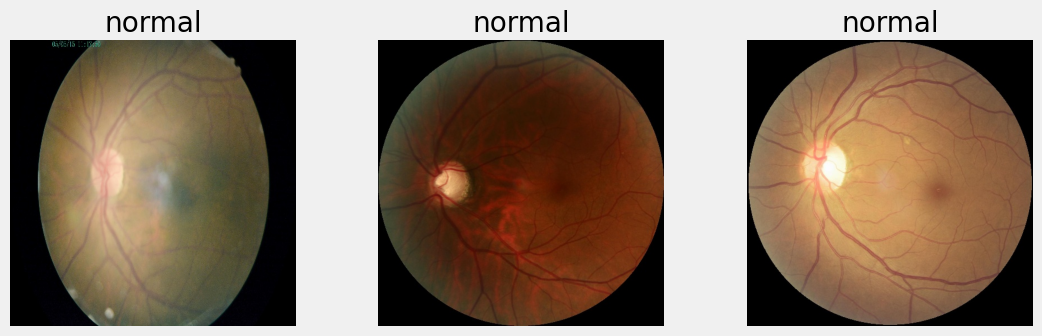

In [ ]:
plot_image(2)

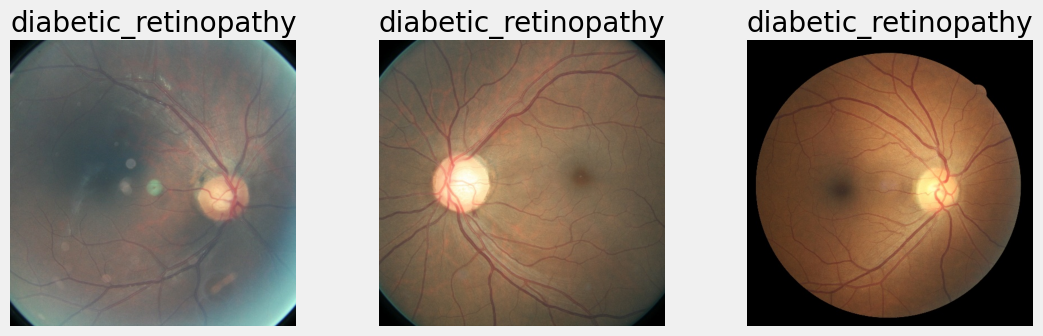

In [ ]:
plot_image(3)

In [ ]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [ ]:
df.disease_type.value_counts()

disease_type
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [ ]:
# shuffling the rows of a DataFrame df
df1=df.sample(frac=1).reset_index(drop=True)

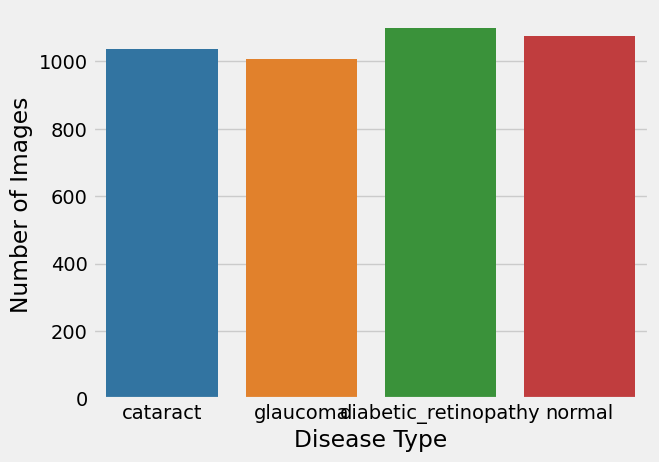

In [ ]:
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Assuming 'df1' contains your DataFrame with 'disease_type' column
sns.countplot(x='disease_type', data=df1, palette=custom_palette)
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')

# Save the plot as an image
plt.savefig('countplot.png')

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

# Data Training& Testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into features (X) and labels (y)
X = df1['image']  # 'image' contains image data
y = df1['disease_type']  # 'disease_type' contains labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [ ]:
# Data generators for training
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [ ]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [ ]:
# Check if class indices are consistent
if (train_data.class_indices == valid_data.class_indices):

    # Print that the class indices are consistent
    print("Class indices are consistent")

    # Save class indices as metadata in metadata.js
    class_indices = train_data.class_indices
    print(class_indices)
    js_code = f"const classIndices = {class_indices};\nexport default classIndices;"
    with open('metadata.js', 'w') as f:
        f.write(js_code)
else:
    print("Class indices are not consistent")

Class indices are consistent
{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


# Building The Model

In [ ]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from keras.models import Sequential


In [ ]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
image_size=224
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

model = Sequential()
model.add(vgg)
model.add(Flatten())


model.add(Dense(256,activation = "relu"))

model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(4,activation="softmax"))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 26,449,220
Trainable params: 6,424,324
Non-trainable params: 20,024,896
__________________________________

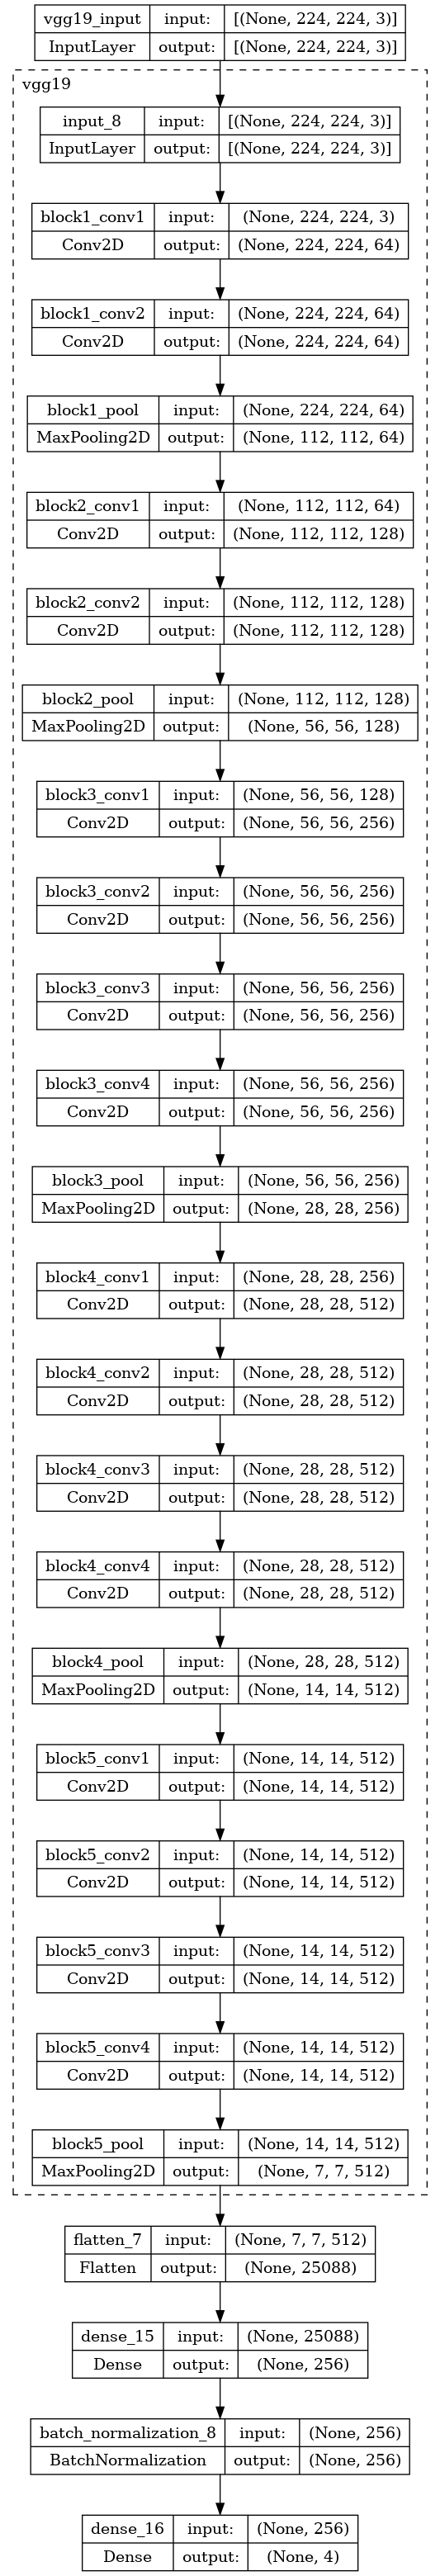

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
his = model.fit(
    train_data,       # Training data
    batch_size=32,    # Batch size for training
    epochs=32,        # Number of training epochs
    validation_data=valid_data,  # Validation data
    verbose=1,        # Verbosity level for training logs
    callbacks=[checkpoint, earlystop]  # Callback functions
)


Epoch 1/32
106/106 [==============================] - 34s 305ms/step - loss: 0.5453 - accuracy: 0.7949 - val_loss: 0.4443 - val_accuracy: 0.8517
Epoch 2/32
106/106 [==============================] - 32s 307ms/step - loss: 0.2801 - accuracy: 0.8903 - val_loss: 0.4843 - val_accuracy: 0.8624
Epoch 3/32
106/106 [==============================] - 33s 311ms/step - loss: 0.2239 - accuracy: 0.9143 - val_loss: 0.4288 - val_accuracy: 0.8482
Epoch 4/32
106/106 [==============================] - 33s 306ms/step - loss: 0.1623 - accuracy: 0.9401 - val_loss: 0.2951 - val_accuracy: 0.9134
Epoch 5/32
106/106 [==============================] - 33s 308ms/step - loss: 0.1359 - accuracy: 0.9499 - val_loss: 0.5139 - val_accuracy: 0.8505
Epoch 6/32
106/106 [==============================] - 33s 310ms/step - loss: 0.1265 - accuracy: 0.9570 - val_loss: 0.4068 - val_accuracy: 0.8766
Epoch 7/32
106/106 [==============================] - 33s 308ms/step - loss: 0.1113 - accuracy: 0.9591 - val_loss: 0.3650 - val_ac

In [ ]:

loss, accuracy = model.evaluate(valid_data)
print("Loss:", loss)
print("Accuracy:", accuracy)

27/27 [==============================] - 7s 267ms/step - loss: 0.5208 - accuracy: 0.8743
Loss: 0.5207515358924866
Accuracy: 0.8742585778236389


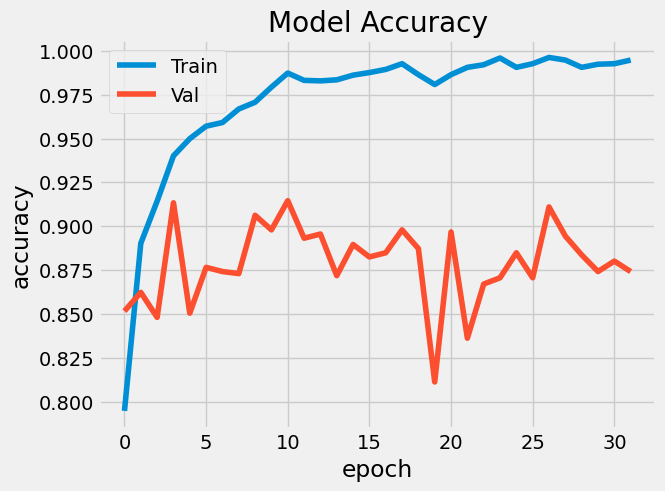

In [ ]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

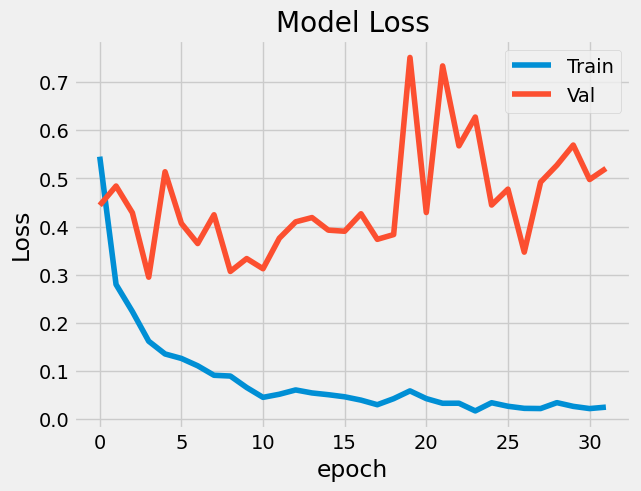

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

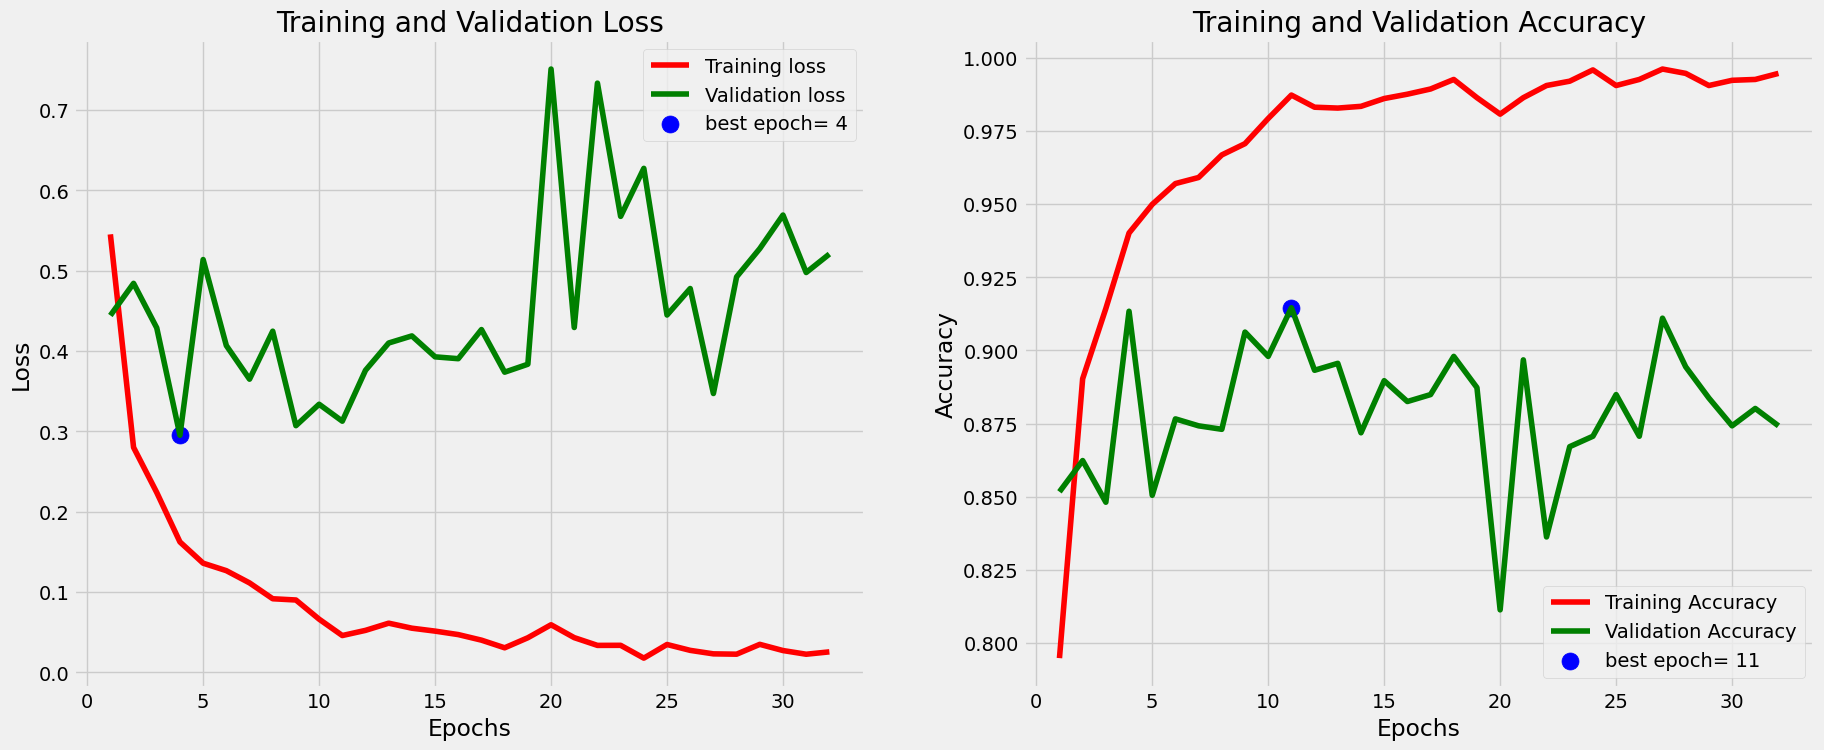

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the history
tr_plot(his,0)
plt.savefig('history.png')


# Model Evaluation

In [ ]:
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 7s 262ms/step


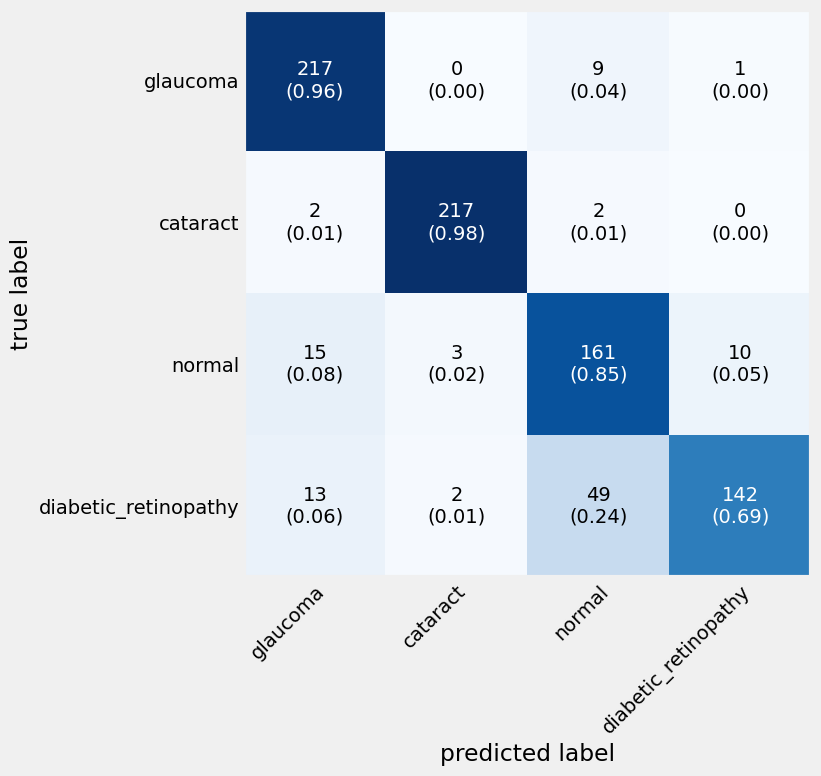

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"],
                      show_normed = True);
plt.savefig("Predected & True Label")

In [ ]:
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.88      0.96      0.92       227
diabetic_retinopathy       0.98      0.98      0.98       221
            glaucoma       0.73      0.85      0.79       189
              normal       0.93      0.69      0.79       206

            accuracy                           0.87       843
           macro avg       0.88      0.87      0.87       843
        weighted avg       0.88      0.87      0.87       843



1/1 [==============================] - 0s 179ms/step


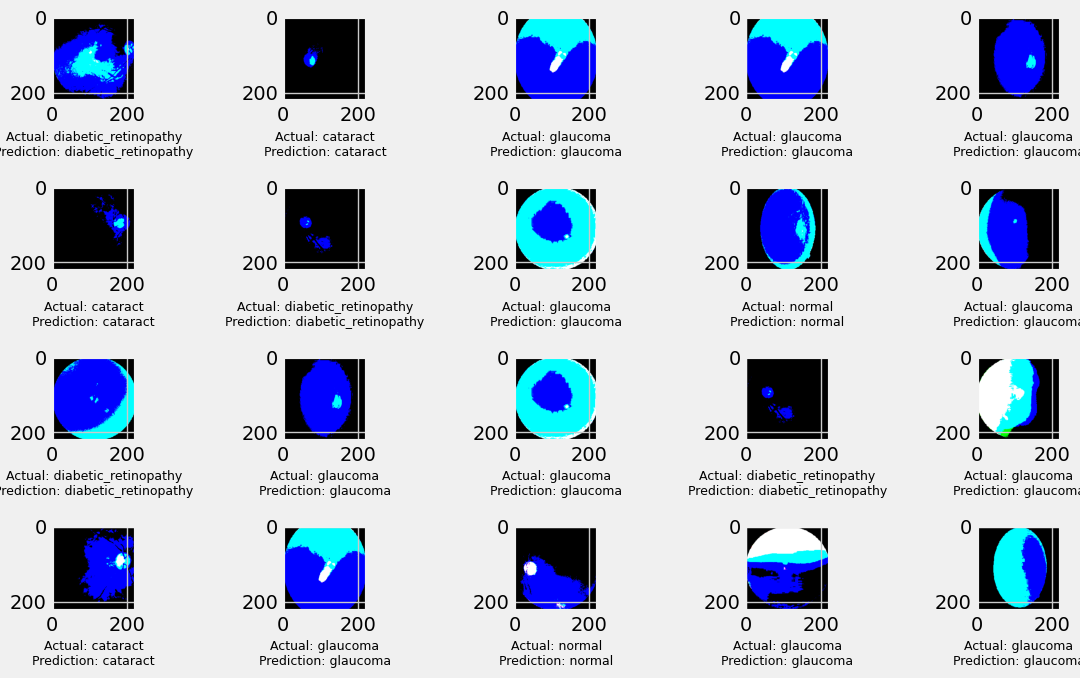

In [ ]:
import random
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"]

# Get a batch of data from the valid_data generator
images, labels = next(valid_data)

# Replace these variables with your actual data
y_pred = model.predict(images)  # Assuming you have a trained model

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)

    # Change the font size for labels
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)  # Change the fontsize as needed

plt.tight_layout()

# Save the plot as an image
plt.savefig('Model Eval.png')

plt.show()

In [ ]:
model.save("Eye Disease Classification")